In [2]:
import sys
sys.path.insert(1, './supportingexamples')
import examples

# MPNN
Let us reconsider RNNs again. We calculate state of a node, $h$, and then pass it on to the next node. We are not restricted to "positive" direction of time. We can go backward. We can also stack up the layers and thus moving upwards, or downwards. Skip connections further muddle the idea of sequential time. If we take step back and consider doing a propagation step in a graph and compute a path in a graph, we have created a sequence and all things RNN can be applied to that path.

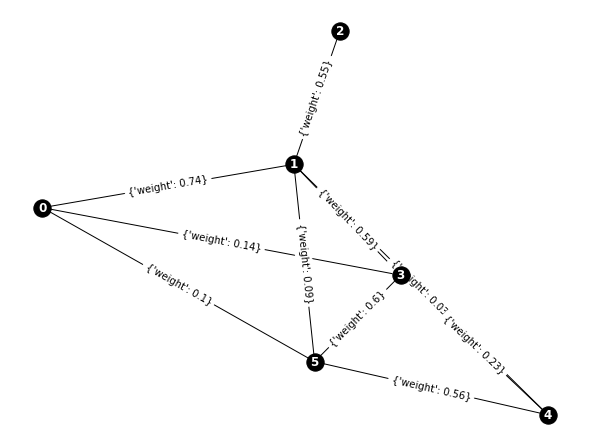

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import random
random.seed(42)
N = 6
DROP_RATE=.5
G = nx.complete_graph(N)
G.remove_edges_from(random.sample(G.edges(),k=int(DROP_RATE*G.number_of_edges())))
G.add_edges_from([(5,0),(1,0)])
for (u,v,w) in G.edges(data=True):
    w['weight'] = round(random.random(), 2)
 
pos = nx.spring_layout(G)
plt.figure(3,figsize=(8,6))

nx.draw(G, pos=pos, with_labels=True, node_color='black', font_color='white', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos=pos)
plt.show()

In [10]:
a = nx.all_shortest_paths(G, source=4, target=0, weight='weigth')
len_a = 0
for path in a:
    print(path)
    len_a += 1

[4, 1, 0]
[4, 3, 0]
[4, 5, 0]


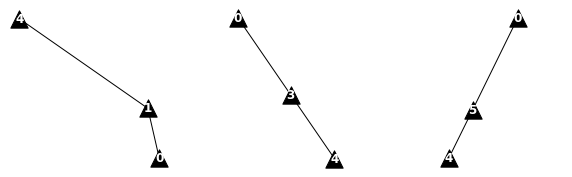

In [5]:
fig, ax = plt.subplots(1, len_a, figsize=(10,3))
a = nx.all_shortest_paths(G, source=4, target=0, weight='weigth')
i = 0
for path in a:
    graph = nx.subgraph(G, path)
    nx.draw(graph, with_labels=True, node_color='black', font_color='white', font_weight='bold', ax=ax[i], node_shape='^')
    ax[i].set_axis_off()
    i += 1
plt.show()

Now try to imagine increasing the paths to all possible paths, then the graph theoretically has become a series of RNNs. If we consider time-steps $t_1, t_2, t_3$, then we can create some sort of aggregation similar to RNNs. To encode a path, such as [4, 1, 0], we could For instance, do a weighted sum. In this case, of value of 0, 1, and 4 are respectively 5, 6, 7. We already know that weight values for (0, 1), (1, 4) are .74 and .03 respectively. if we are at 0 at timestep 0, 1 at timestep 1, and 4 at timestep 2, then $m_{4}^{2}=M(5 \times .74 + 6 \times .03 = 3.88$), where $\Phi$ is some function; M can be a simple liner function, concatenation, or even a neural network. We then use a non-liner update function $U$ to update the value of the node state. In this example, $h_{4}^{2}=U_4(h_{1}^{4}, m_{4}^{2})$  

You can observe that in this simple example we have skipped value of the destination node. This results in ignoring correlation between edge and state nodes similar to early version of MPNN [Duevenaud, 2015]

## MPNN Intuition
There are several MPNN frameroks. Here I will explore a few of them. Forward pass of MPNN has two phases, Message Passing phase and readout phase. 

Message passing phase consists of message function $M$ over $T$ timesteps and update function $U$ over the same number of timesteps. during message passing state, hidden stats of a node is is updated based on an aggregation on stated of neighboring nodes and properties of the edges connecting the target node with its neighbors.


We shall need an encoding mechanism to captures node and edged features. We can for instance cerate a one-hot vector of all features and then combine multi-features through concatenation or other means.

The readout phase, not dissimilarly to encoder in the encoder-decoder architecture, computes a feature vector for the whole graph. The readout phase uses a readout function that can be a neural network.

Let us try an example. In the world of Marry, if we want to to encode Mary, we can set hyperparameter $T$ to 2 and use message processing to propagate and update Mary's state. The figure below captures the subgraph that is used for MPNN.

In [12]:
#importlib.reload(examples) 
_,f = examples.world_of_mary()
g,a=examples.get_ego(node='Mary', radius=1)
print("all edge features: {}\nedge featured for marry at T==2: {}".format(list(set(f.values())), 
                                                                          list(set(a.values()))))

all edge features: ['works', 'likes', 'loves', 'sibling', 'colleagues', 'is', 'contains']
edge featured for marry at T==2: ['sibling', 'works', 'is', 'likes']


the code snippet above demonstrates that for instance the edge between Mary and Tom could be presented as: $[1, 0, 0, 0, 0, 0, 0]$. If there has been an edge describing that Mary "likes" her brother, Tom, then the edge feature vector would look like $[1, 1, 0, 0, 0, 0, 0]$. As both Tom and Mary work in amazon, they are colleagues. In the example, this is a missing edge that could be predicted, but if we imagine the "colleague" relationship as a part of our data, then the feature vector would look like: $[1, 1, 0, 1, 0, 0, 0]$. 
We might also have node features such as Tom is a 25-33 male, 180-cm tall and BMI index of 18. This could also be combined and perhaps pass through an embedding layer to create a latent feature vector, which is in agreement with the edge feature vector in terms of shapes of the two vectors. We can then calculate:

$$m^{mary}_{1 \times 7} = \sum{[(tom,cheese, likes), \\(tom,vegetarian, is), \\(tom, amazon, works), \\(mary,tom, sibling), (mary,cheese, likez), \\(mary, amazon, works), \\(mary, vegeterian, is), \\(tom, mary, sibling)\large ]} $$ 
Finally, we can build an MLP, $U^{mary}$, that takes $m^{mary}_{1 \times 7}$ and current $h^{mary}$ before the update and assigns Mary a new state:


$$
h^{mary}_{next}=U^{mary}(h^{mary}_{current}, m^{mary}_{1 \times 7}),\text{where U is a neural network}
$$

For the readout phase we can imagine using a neural network 
$$
\phi(\sigma (h_{mary}\odot h_{tom} \odot h_{cheese} \odot h_{vegtn} \odot h_{amazon}))
$$


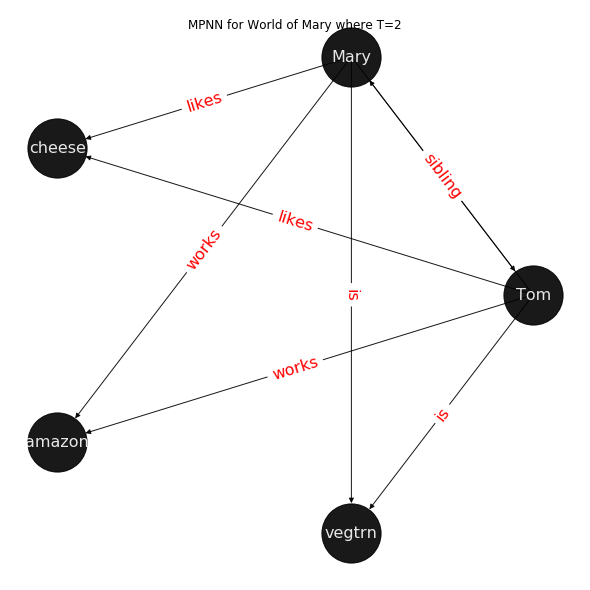

In [32]:
examples.draw_world_of_mary(g,a, 
                            fig_size=(8,8), 
                            length=10, 
                            pos=nx.circular_layout(g), 
                            title="MPNN for World of Mary where T=2")

## MPNN formalization
Graph $\mathcal {G} = (V,E)$ is am undirected and simple graph where $v,w \in V\ and\ (v,w)\in V$. $x_v$ is edge feature vector for edge $v$ and $e_{v,w}$ is the feature vector for edge connecting $v$ and $w$.

The forward pass includes, as we have seen, a propagation and an update phase. The propagation phase in general is calculating message for the next timestep based on current state of a vertex $v$, states of all the connected vertices in $v$'s neighborhood, and edge features of all of $v$'s neighbors. We then use this message and value of current hidden state of node $v$ to update the node with the new value.
$$
m_v^{t+1}=\sum_{w \in \mathcal{N}_(v)}\mathcal{M}_t(h^t_v, h^t_w, e_{vw})\\
h^{t+1}_v=\mathcal {U}_t(h_v^t, m_v^{t+1})
$$
The readout phase, calculates a feature vector for the whole graph using some readout function $\mathcal {R}$:
$$
\hat{y} = \mathcal {R}({h_v^T} \vert v \in \mathcal{G})
$$

$\mathcal{M_t}$, $\mathcal{U_t}$, and $\mathcal{R}$ are learned differentiable functions.



## Invariance
In Mary's world, the result of MPNN process should be independent of the starting point. Mary's node features should be the same if we start the MPNN process from 'vegtrn' node or from 'tom'. If this does not hold and MPNN does not exhibit invariance to graph isomorphism, then depending on starting point, we would need to retrain the model.
we, thus, need MPNN to be invariant to graph isomorphism, meaning relabeling of nodes should not affect messaging process. This is achieved if $\mathcal{R}$ is invariant to permutation of node states while processing graphs' feature vector.

## Variations of MPNN.
There are several flavours of MPNN, but before going there, let us use a simple implementation using Deep Graph Library.

references: Neural Message Passing for Quantum Chemistry Gilmer et. al, 	arXiv:1704.01212 [cs.LG]